In [2]:
import numpy as np
import pandas as pd
import scipy.io
from scipy import stats

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm
import os

# Func & Load

In [3]:
def load_metadata(root_path, paradigm_setting, session_num):
    meta = pd.read_excel(root_path + 'mat/adp_dataset_master.xlsx', index_col=None)
    meta = meta[meta.paradigm == paradigm_setting].reset_index()
    meta = meta[['mouse','date','area','num']]

    meta.mouse = meta.mouse.astype(int)
    
    if isinstance(session_num, int):
        meta.date = meta.date.astype(int).astype(str) + '_00' + meta.num.astype(int).astype(str) + '_caiman'
        meta.num = meta.num.astype(int)
        meta = meta.loc[meta['num'] == session_num].reset_index()
    elif session_num == '':
        meta.date = meta.date.astype(int).astype(str) + '_caiman'
        meta = meta.head(1) # multisession, only keep one metadata
    return meta

In [6]:
root_path = 'C:/Users/ll357/Documents/inter/'
meta = load_metadata(root_path, paradigm_setting='bunnytop', session_num='')
print(meta)

dir_name = root_path + 'mat/'
iset = 0
dir_sub = str(meta.area[iset]) + '_i' + str(meta.mouse[iset]) + '_' + str(meta.date[iset])

dfof_trialwise = scipy.io.loadmat(os.path.join(dir_name, dir_sub, 'resp_base_trialwise' + '.mat'))
# dfof_trialwise.keys(), dfof_trialwise['dfof_ad_trial'].shape, dfof_trialwise['dfof_ad_trial'][0,0].shape

dfof_ad_trial = dfof_trialwise['dfof_ad_trial'] #- dfof_trialwise['dfof_base_trial'] # subtract baseline???
dfof_tg_trial = dfof_trialwise['dfof_tg_trial'] #- dfof_trialwise['dfof_base2_trial']

   mouse           date area  num
0   1350  211222_caiman   V1  2.0


In [9]:
dfof_trialwise.keys(), dfof_trialwise['dfof_ad_trial'].shape, dfof_trialwise['dfof_ad_trial'][0,0].shape

(dict_keys(['__header__', '__version__', '__globals__', 'dfof_ad_trial', 'dfof_base2_trial', 'dfof_base_trial', 'dfof_tg_trial']),
 (391, 30),
 (49, 1))

# One way anova

In [77]:
atlanta = [13.75, 13.75, 13.5, 13.5, 13.0, 13.0, 13.0, 12.75, 12.5]
chicago = [14.25, 13.0, 12.75, 12.5, 12.5, 12.4, 12.3, 11.9, 11.9]
houston = [14.0, 14.0, 13.51, 13.5, 13.5, 13.25, 13.0, 12.5, 12.5]
memphis = [15.0, 14.0, 13.75, 13.59, 13.25, 12.97, 12.5, 12.25,
          11.89]
p = stats.alexandergovern(atlanta, chicago, houston, memphis)
print(p)
type(p)

AlexanderGovernResult(statistic=4.65087071883494, pvalue=0.19922132490385214)


types.AlexanderGovernResult

In [79]:
ncell = dfof_ad_trial.shape[0]
nstim = dfof_ad_trial.shape[1]

p_anova = np.ones((ncell, 1)) * np.nan
p_kruskal = np.ones((ncell, 1)) * np.nan
# p_alexandergovern = np.ones((ncell, 1)) * np.nan

for icell in tqdm(np.arange(ncell)):
    base_cell = np.concatenate([dfof_trialwise['dfof_base_trial'][icell, stim] for stim in range(nstim)])
    stim_cell = [] 
    for istim in np.arange(nstim):
        stim_cell.append(np.array(dfof_ad_trial[icell, istim]).flatten())
    
    _, p_anova_cell = stats.f_oneway(np.array(base_cell).flatten(), *stim_cell)
    p_anova[icell] = p_anova_cell
    _, p_kruskal_cell = stats.kruskal(np.array(base_cell).flatten(), *stim_cell)
    p_kruskal[icell] = p_kruskal_cell
    # _, p_alexandergovern_cell = stats.alexandergovern(np.array(base_cell).flatten(), *stim_cell)
    # p_alexandergovern[icell] = p_alexandergovern_cell
    # print(stats.alexandergovern(np.array(base_cell).flatten(), *stim_cell))

100%|██████████| 391/391 [00:00<00:00, 610.79it/s]


array([30])

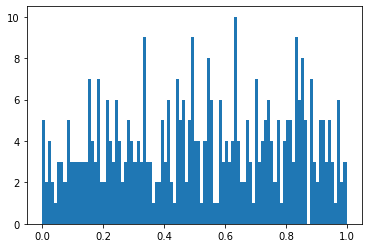

In [42]:
plt.hist(p_anova, 100);
sum(p_anova < 0.1)

array([34])

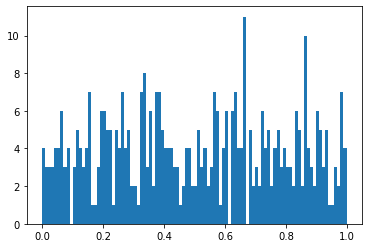

In [68]:
plt.hist(p_kruskal, 100);
sum(p_kruskal < 0.1)

# One tail ttest